In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, autograd
from torch.nn import functional as F

import numpy as np
import scipy.spatial
import math
import os
import pyemma as pe
from mpl_toolkits import mplot3d
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
Dx = 2
N =10000
kBT = 20
repeat_times = 100

aa = [-1, -1, -6.5, 0.7]
bb = [0, 0, 11, 0.6]
cc = [-10, -10, -6.5, 0.7]
AA = [-200, -100, -170, 15]
XX = [1, 0, -0.5, -1]
YY = [0, 0.5, 1.5, 1]
sigma = 0.05
os.makedirs('./Data', exist_ok=True)
USE_GPU = torch.cuda.is_available()

In [3]:
def get_V(px):
    px = np.array(px)
    ee = 0
    if np.size(px.shape) == 2:
        for j in range(4):
            ee = ee + AA[j] * np.exp(aa[j] * (px[:, 0] - XX[j]) ** 2 +
                                              bb[j] * (px[:, 0] - XX[j]) * (px[:, 1] - YY[j]) +
                                              cc[j] * (px[:, 1] - YY[j]) ** 2)
        ee += 9 * np.sin(2 * 5 * np.pi * px[:, 0]) * np.sin(2 * 5 * np.pi * px[:, 1])
        for i in range(2, Dx):
            ee += px[:, i] ** 2 / 2 / sigma ** 2
    else:
        for j in range(4):
            ee = ee + AA[j] * np.exp(aa[j] * (px[0] - XX[j]) ** 2 +
                                              bb[j] * (px[0] - XX[j]) * (px[1] - YY[j]) +
                                              cc[j] * (px[1] - YY[j]) ** 2)
        ee += 9 * np.sin(2 * 5 * np.pi * px[0]) * np.sin(2 * 5 * np.pi * px[1])
        for i in range(2, Dx):
            ee += px[i] ** 2 / 2 / sigma ** 2
    return ee

In [4]:
def get_grad(px):
    px = np.array(px)
    gg = np.zeros(shape=(Dx,), dtype=np.float64)
    for j in range(4):
        ee = AA[j] * np.exp(aa[j] * (px[0] - XX[j]) ** 2 +
                                     bb[j] * (px[0] - XX[j]) * (px[1] - YY[j]) +
                                     cc[j] * (px[1] - YY[j]) ** 2)
        gg[0] = gg[0] + (2 * aa[j] * (px[0] - XX[j]) +
                             bb[j] * (px[1] - YY[j])) * ee
        gg[1] = gg[1] + (bb[j] * (px[0] - XX[j]) +
                             2 * cc[j] * (px[1] - YY[j])) * ee
    gg[0] += 9 * 2 * 5 * np.pi * np.cos(2 * 5 * np.pi * px[0]) * np.sin(2 * 5 * np.pi * px[1])
    gg[1] += 9 * 2 * 5 * np.pi * np.sin(2 * 5 * np.pi * px[0]) * np.cos(2 * 5 * np.pi * px[1])
    for i in range(2, Dx):
        gg[i] = px[i] / sigma ** 2
    return gg

In [5]:
def sim_data(kBT, dt, D_size, firstsave=1000, t_sep=100):
    D = []
    px = np.zeros((Dx,))
    id_ = 0
    i = 0
    while True:
        px = px - dt * get_grad(px) + np.sqrt(2 * kBT * dt) * np.random.normal(size=(Dx,))
        if i >= firstsave and i % t_sep == 0 and 1 >= px[0] >= -1.5 \
                and 2 >= px[1] >= -0.5:
            D.append(px)
            id_ += 1
            if id_ >= D_size:
                break
        i += 1
    data = np.zeros((D_size, 1 + Dx))
    data[:, 1:] = np.array(D)
    data[:, 0] = get_V(D)
    print('generating data finished!')
    return data

/Users/junowang/anaconda3/lib/python3.7/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.6.
  .format(latest=latest, current=current), category=UserWarning)


In [49]:
data_ori = []
for i in range(repeat_times):
    data_ori_t = sim_data(kBT = kBT, dt = 1e-5, D_size = N)
    data_ori.extend(data_ori_t)
print(np.shape(data_ori))

KeyboardInterrupt: 

In [ ]:
np.savetxt('Data/data_'+str(N)+'_'+str(kBT)+'_'+str(repeat_times),data_ori)

In [6]:
data_ori = np.loadtxt('Data/data_'+str(N)+'_'+str(kBT)+'_'+str(repeat_times)).reshape(-1,3)

In [7]:
print(np.shape(data_ori))

(1000000, 3)


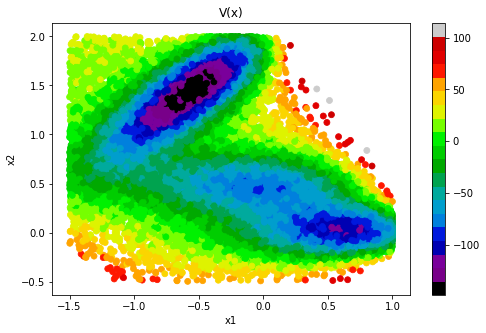

In [103]:
fig, ax = plt.subplots(figsize=(8, 5))
pic1 = ax.scatter(data_ori[:, 1], data_ori[:, 2], marker='o',lw = 0.75,c=data_ori[:,0], cmap = plt.cm.get_cmap('nipy_spectral', 20))
ax.set_title('V(x)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
fig.colorbar(pic1)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9fc0d4f320>)

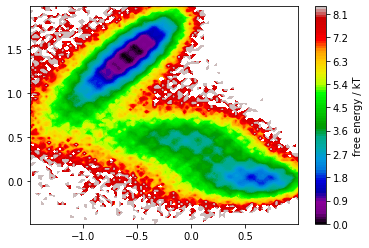

In [104]:
pe.plots.plot_free_energy(data_ori[:,1],data_ori[:,2])

In [20]:
X0 = torch.from_numpy(data_ori[:30000, 1:]).float()
X1 = torch.from_numpy(data_ori[50:30050, 1:]).float()
print(X0.size())
tau = 0.05

torch.Size([30000, 2])


In [21]:
train_batch_size = 128

train_loader = torch.utils.data.DataLoader(
    torch.cat([X0, X1], 1), batch_size = train_batch_size, shuffle = True)

In [26]:
Dv = Dx


V_net = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, Dv)
    )

D_net = nn.Sequential(
    nn.Linear(2*Dv, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.LogSoftmax()
    )


In [27]:
def learn_D(data_X0, data_X1, V_net, D_net , optimizer_D):


    if USE_GPU:
        data_X0 = data_X0.cuda()
        data_X1 = data_X1.cuda()
    
#     data_X1_tilde = V_net(data_X0) + sqrt(2*tau)*torch.randn(V_net(data_X0).size())
    data_X1_tilde = data_X0 - V_net(data_X0)*tau + sqrt(2*tau)*torch.randn(V_net(data_X0).size())
    
    D1 = D_net(torch.cat([data_X0, data_X1], 1))[:,0]
    D2 = D_net(torch.cat([data_X0, data_X1_tilde], 1))[:,1]
    
    loss = 0.
    D_loss = -D1.mean() - D2.mean()
    loss += D_loss

     
    optimizer_D.zero_grad()
    loss.backward()
    optimizer_D.step()



    return -D_loss.item()

In [28]:
def learn_V(data_X0, data_X1, V_net, D_net, optimizer_V):


    if USE_GPU:
        data_X0 = data_X0.cuda()
        data_X1 = data_X1.cuda()
 
     
#     data_X1_tilde = V_net(data_X0) + sqrt(2*tau)*torch.randn(V_net(data_X0).size())
    data_X1_tilde = data_X0 - V_net(data_X0)*tau + sqrt(2*tau)*torch.randn(V_net(data_X0).size())
    
    loss = 0.
    V_loss =  D_net(torch.cat([data_X0, data_X1_tilde], 1))[:,1].mean()
#     print(D_net(torch.cat([data_X0, data_X1_tilde], 1)))
    loss += V_loss

     
    optimizer_V.zero_grad()
    loss.backward()
    optimizer_V.step()


    return V_loss.item()

In [47]:
lr = 1e-4
optimizer_D = optim.Adam(list(D_net.parameters()), lr=lr)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=25, gamma=0.1)

optimizer_V = optim.Adam(list(V_net.parameters()), lr=lr)
scheduler_V = torch.optim.lr_scheduler.StepLR(optimizer_V, step_size=25, gamma=0.1)

n_epochs = 20
train_data_size = len(train_loader.dataset)
for epoch in range(1, n_epochs + 1):
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):

        actual_size = len(data)
        data = data
        data_X0 = data[:, :Dx]
        data_X1 = data[:, Dx:]
        
        
        D_loss = learn_D(data_X0, data_X1, V_net, D_net, optimizer_D)
        learn_V(data_X0, data_X1, V_net, D_net , optimizer_V)
        

        train_loss += D_loss * len(data)
        


    train_loss /= len(train_loader.dataset)
    if train_loss > -0.5:
        break
    
    if epoch % 1 == 0:
        print('Train Epoch: {} ===> Train set loss: {:.4f}'.format(epoch, train_loss))
        
    scheduler_D.step()
    scheduler_V.step()

    

Train Epoch: 1 ===> Train set loss: -0.9155
Train Epoch: 2 ===> Train set loss: -0.9231
Train Epoch: 3 ===> Train set loss: -0.9212
Train Epoch: 4 ===> Train set loss: -0.9197
Train Epoch: 5 ===> Train set loss: -0.9228
Train Epoch: 6 ===> Train set loss: -0.9205
Train Epoch: 7 ===> Train set loss: -0.9202
Train Epoch: 8 ===> Train set loss: -0.9171
Train Epoch: 9 ===> Train set loss: -0.9158
Train Epoch: 10 ===> Train set loss: -0.9179
Train Epoch: 11 ===> Train set loss: -0.9194
Train Epoch: 12 ===> Train set loss: -0.9194
Train Epoch: 13 ===> Train set loss: -0.9208
Train Epoch: 14 ===> Train set loss: -0.9175
Train Epoch: 15 ===> Train set loss: -0.9136
Train Epoch: 16 ===> Train set loss: -0.9123
Train Epoch: 17 ===> Train set loss: -0.9157
Train Epoch: 18 ===> Train set loss: -0.9114
Train Epoch: 19 ===> Train set loss: -0.9171
Train Epoch: 20 ===> Train set loss: -0.9141


In [48]:
V = V_net(X0).detach().numpy()
print(np.shape(V))
# X1_tilde = V + np.random.randn(np.shape(V)[0],np.shape(V)[1])*sqrt(2)*tau
X1_tilde = X0.detach().numpy() - V*tau + np.random.randn(np.shape(V)[0],np.shape(V)[1])*sqrt(2*tau)
print(np.shape(X1_tilde))
X1_real = X1.detach().numpy()
print(np.shape(X1_real))

(30000, 2)
(30000, 2)
(30000, 2)


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0cf4c9828>)

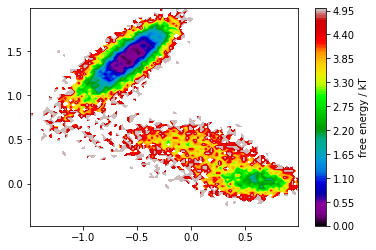

In [49]:
pe.plots.plot_free_energy(X1_real[:,0],X1_real[:,1])

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ce965390>)

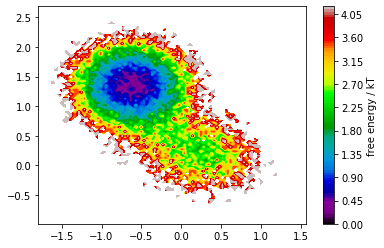

In [50]:
pe.plots.plot_free_energy(X1_tilde[:,0],X1_tilde[:,1])

In [51]:
V_grad_X0_real = []
for i in range(np.shape(X0)[0]):
    temp = get_grad(X0.detach().numpy()[i,:])
    V_grad_X0_real.append(temp)

print(np.shape(V_grad_X0_real))

(30000, 2)


In [52]:
V_grad_X0_approx = V_net(X0).detach().numpy()
print(np.shape(V_grad_X0_approx))

(30000, 2)


In [53]:
err = mean_squared_error(V_grad_X0_real, V_grad_X0_approx)
print(err)

49982.14302698907
